Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  labels = np.squeeze(labels)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

We're first going to train a multinomial logistic regression using stochastic gradient descent.

In [5]:
batch_size = 128
beta_val = np.logspace(-4,-2,20)
accuracy_val = []

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases   
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
    labels=tf_train_labels, logits=logits)
    ) + tf_beta_regul * tf.nn.l2_loss(weights)

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  # valid_prediction = tf.nn.softmax(
  #  tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

Initialized
beta: 0.00010, test accuracy: 87.1%
beta: 0.00013, test accuracy: 88.4%
beta: 0.00016, test accuracy: 88.9%
beta: 0.00021, test accuracy: 89.2%
beta: 0.00026, test accuracy: 89.2%
beta: 0.00034, test accuracy: 89.2%
beta: 0.00043, test accuracy: 89.3%
beta: 0.00055, test accuracy: 89.2%
beta: 0.00070, test accuracy: 89.2%
beta: 0.00089, test accuracy: 89.2%
beta: 0.00113, test accuracy: 89.2%
beta: 0.00144, test accuracy: 89.1%
beta: 0.00183, test accuracy: 89.1%
beta: 0.00234, test accuracy: 89.1%
beta: 0.00298, test accuracy: 89.1%
beta: 0.00379, test accuracy: 89.0%
beta: 0.00483, test accuracy: 89.0%
beta: 0.00616, test accuracy: 88.9%
beta: 0.00785, test accuracy: 88.7%
beta: 0.01000, test accuracy: 88.6%
Best accuracy is 89.3% when beta is 0.00043


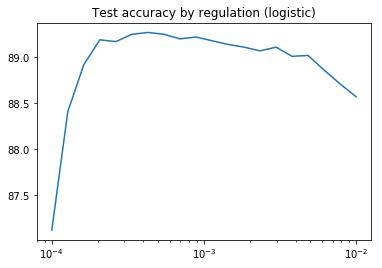

In [6]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for beta in beta_val:
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,
                    tf_beta_regul: beta}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict) 
      
      test_accuracy = accuracy(test_prediction.eval(), test_labels)
      accuracy_val.append(test_accuracy)
      print("beta: %.5f, test accuracy: %.1f%%" % (
            beta, test_accuracy))
  
  print("Best accuracy is %.1f%% when beta is %.5f" % (
      max(accuracy_val), beta_val[np.argmax(accuracy_val)]))
  plt.semilogx(beta_val,accuracy_val)
  plt.title('Test accuracy by regulation (logistic)')
  plt.show()

  
      

Create the graph for 1-hidden layer neural network with rectified linear units nn.relu() and 1024 hidden nodes.

In [8]:
batch_size = 128
hidden_size = 1024
accuracy_nn_val = []

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_size]))
  biases_1 = tf.Variable(tf.zeros([hidden_size]))
  weights_2 = tf.Variable(
    tf.truncated_normal([hidden_size, num_labels]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  y_1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
  logits = tf.matmul(y_1, weights_2) + biases_2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
    ) + tf_beta_regul * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2)) 


  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  '''
  valid_prediction_temp = tf.nn.relu(tf.matmul(
      tf_valid_dataset, weights_1) + biases_1)
  valid_prediction = tf.nn.softmax(
      tf.matmul(valid_prediction_temp,weights_2) + biases_2)
  '''

  test_prediction_temp = tf.nn.relu(tf.matmul(
      tf_test_dataset, weights_1) + biases_1)
  test_prediction = tf.nn.softmax(
      tf.matmul(test_prediction_temp,weights_2) + biases_2)

Let's run it:

Initialized
beta: 0.00010, test accuracy: 90.2%
beta: 0.00013, test accuracy: 91.5%
beta: 0.00016, test accuracy: 92.8%
beta: 0.00021, test accuracy: 93.6%
beta: 0.00026, test accuracy: 94.2%
beta: 0.00034, test accuracy: 94.5%
beta: 0.00043, test accuracy: 94.7%
beta: 0.00055, test accuracy: 95.0%
beta: 0.00070, test accuracy: 94.7%
beta: 0.00089, test accuracy: 94.7%
beta: 0.00113, test accuracy: 94.3%
beta: 0.00144, test accuracy: 94.0%
beta: 0.00183, test accuracy: 93.6%
beta: 0.00234, test accuracy: 93.1%
beta: 0.00298, test accuracy: 92.7%
beta: 0.00379, test accuracy: 92.4%
beta: 0.00483, test accuracy: 92.0%
beta: 0.00616, test accuracy: 91.5%
beta: 0.00785, test accuracy: 91.0%
beta: 0.01000, test accuracy: 90.3%
Best accuracy is 95.0% when beta is 0.00055


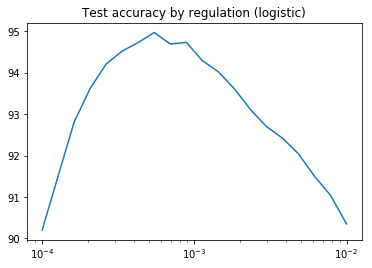

In [7]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for beta in beta_val:
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,
                    tf_beta_regul: beta}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict) 
      
      test_accuracy = accuracy(test_prediction.eval(), test_labels)
      accuracy_nn_val.append(test_accuracy)
      print("beta: %.5f, test accuracy: %.1f%%" % (
            beta, test_accuracy))
  
  print("Best accuracy is %.1f%% when beta is %.5f" % (
      max(accuracy_nn_val), beta_val[np.argmax(accuracy_nn_val)]))
  plt.semilogx(beta_val,accuracy_nn_val)
  plt.title('Test accuracy by regulation (logistic)')
  plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [8]:
batch_size = 128
hidden_size = 1024
accuracy_nn_val = []

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_size]))
  biases_1 = tf.Variable(tf.zeros([hidden_size]))
  weights_2 = tf.Variable(
    tf.truncated_normal([hidden_size, num_labels]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  y_1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
  logits = tf.matmul(y_1, weights_2) + biases_2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
    ) + tf_beta_regul * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2)) 


  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  '''
  valid_prediction_temp = tf.nn.relu(tf.matmul(
      tf_valid_dataset, weights_1) + biases_1)
  valid_prediction = tf.nn.softmax(
      tf.matmul(valid_prediction_temp,weights_2) + biases_2)
  '''

  test_prediction_temp = tf.nn.relu(tf.matmul(
      tf_test_dataset, weights_1) + biases_1)
  test_prediction = tf.nn.softmax(
      tf.matmul(test_prediction_temp,weights_2) + biases_2)

Let's run it:

Initialized
beta: 0.00010, test accuracy: 84.2%
beta: 0.00013, test accuracy: 84.1%
beta: 0.00016, test accuracy: 83.9%
beta: 0.00021, test accuracy: 83.8%
beta: 0.00026, test accuracy: 83.7%
beta: 0.00034, test accuracy: 85.1%
beta: 0.00043, test accuracy: 86.7%
beta: 0.00055, test accuracy: 87.0%
beta: 0.00070, test accuracy: 87.1%
beta: 0.00089, test accuracy: 87.2%
beta: 0.00113, test accuracy: 87.2%
beta: 0.00144, test accuracy: 87.2%
beta: 0.00183, test accuracy: 87.1%
beta: 0.00234, test accuracy: 87.2%
beta: 0.00298, test accuracy: 87.2%
beta: 0.00379, test accuracy: 87.2%
beta: 0.00483, test accuracy: 87.2%
beta: 0.00616, test accuracy: 87.2%
beta: 0.00785, test accuracy: 87.1%
beta: 0.01000, test accuracy: 86.9%
Best accuracy is 87.2% when beta is 0.00298


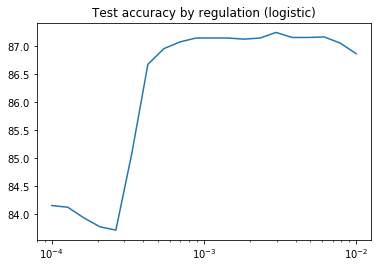

In [9]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for beta in beta_val:
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        offset = (step * batch_size) % (5 * batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,
                    tf_beta_regul: beta}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict) 
      
      test_accuracy = accuracy(test_prediction.eval(), test_labels)
      accuracy_nn_val.append(test_accuracy)
      print("beta: %.5f, test accuracy: %.1f%%" % (
            beta, test_accuracy))
  
  print("Best accuracy is %.1f%% when beta is %.5f" % (
      max(accuracy_nn_val), beta_val[np.argmax(accuracy_nn_val)]))
  plt.semilogx(beta_val,accuracy_nn_val)
  plt.title('Test accuracy by regulation (logistic)')
  plt.show()

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [17]:
batch_size = 128
hidden_size = 1024
beta_val = np.logspace(-4,-2,10)
accuracy_nn_val = []

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_size]))
  biases_1 = tf.Variable(tf.zeros([hidden_size]))
  weights_2 = tf.Variable(
    tf.truncated_normal([hidden_size, num_labels]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  y_1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
  y_1 = tf.nn.dropout(y_1, 0.5) 
  logits = tf.matmul(y_1, weights_2) + biases_2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
    ) + tf_beta_regul * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2)) 


  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  
  valid_prediction_temp = tf.nn.relu(tf.matmul(
      tf_valid_dataset, weights_1) + biases_1)
  valid_prediction = tf.nn.softmax(
      tf.matmul(valid_prediction_temp,weights_2) + biases_2)

  test_prediction_temp = tf.nn.relu(tf.matmul(
      tf_test_dataset, weights_1) + biases_1)
  test_prediction = tf.nn.softmax(
      tf.matmul(test_prediction_temp,weights_2) + biases_2)

Let's run it:

Initialized
beta: 0.00010, test accuracy: 87.3%
beta: 0.00017, test accuracy: 89.4%
beta: 0.00028, test accuracy: 92.0%
beta: 0.00046, test accuracy: 93.1%
beta: 0.00077, test accuracy: 93.2%
beta: 0.00129, test accuracy: 92.9%
beta: 0.00215, test accuracy: 92.2%
beta: 0.00359, test accuracy: 91.5%
beta: 0.00599, test accuracy: 90.7%
beta: 0.01000, test accuracy: 90.0%
Best accuracy is 93.2% when beta is 0.00077


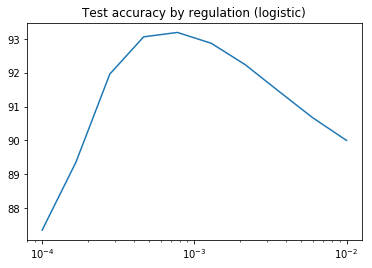

In [18]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for beta in beta_val:
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,
                    tf_beta_regul: beta}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict) 
      
      test_accuracy = accuracy(test_prediction.eval(), test_labels)
      accuracy_nn_val.append(test_accuracy)
      print("beta: %.5f, test accuracy: %.1f%%" % (
            beta, test_accuracy))
  
  print("Best accuracy is %.1f%% when beta is %.5f" % (
      max(accuracy_nn_val), beta_val[np.argmax(accuracy_nn_val)]))
  plt.semilogx(beta_val,accuracy_nn_val)
  plt.title('Test accuracy by regulation (logistic)')
  plt.show()

Extreme overfitting case using 5 training batches:

In [10]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  beta = 0.00055
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    offset = (step * batch_size) % (5 * batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,
                tf_beta_regul: beta}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict) 
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
    
  print('Test accuracy: %.1f%%' % accuracy(
      test_prediction.eval(), test_labels))





Initialized
Minibatch loss at step 0: 604.156982
Minibatch accuracy: 12.5%
Validation accuracy: 26.5%
Minibatch loss at step 500: 132.298309
Minibatch accuracy: 99.2%
Validation accuracy: 78.3%
Minibatch loss at step 1000: 100.776596
Minibatch accuracy: 98.4%
Validation accuracy: 78.2%
Minibatch loss at step 1500: 76.388588
Minibatch accuracy: 100.0%
Validation accuracy: 78.6%
Minibatch loss at step 2000: 58.035969
Minibatch accuracy: 100.0%
Validation accuracy: 78.9%
Minibatch loss at step 2500: 44.087925
Minibatch accuracy: 100.0%
Validation accuracy: 78.9%
Minibatch loss at step 3000: 33.492371
Minibatch accuracy: 100.0%
Validation accuracy: 79.0%
Test accuracy: 86.7%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [ ]:
a 3-layer neural network model

In [116]:
batch_size = 128
hidden_size_1 = 1024 * 2
hidden_size_2 = 1024
hidden_size_3 = 512
accuracy_nn_val = []
decay_steps = 500
decay_rate = 0.8

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_beta_regul = tf.placeholder(tf.float32)

  global_step = tf.Variable(0)  # count the number of steps taken.
  
  # Variables.
  # Set stdandard deviation of weights inversely proportional to the number of inputs into each neuron
  # article about standard deviation setting: https://intoli.com/blog/neural-network-initialization/
  w_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_size_1],
                        stddev = 0.5 * np.sqrt(1.0/(image_size * image_size))))
  b_1 = tf.Variable(tf.zeros([hidden_size_1]))

  w_2 = tf.Variable(
    tf.truncated_normal([hidden_size_1, hidden_size_2],
                        stddev = 0.5 * np.sqrt(1.0/hidden_size_1)))
  b_2 = tf.Variable(tf.zeros([hidden_size_2]))
  '''
  w_3 = tf.Variable(
    tf.truncated_normal([hidden_size_2, num_labels],
                        stddev = 1.0/hidden_size_2))
  b_3 = tf.Variable(tf.zeros([num_labels]))
  '''  
    
  
  w_3 = tf.Variable(
    tf.truncated_normal([hidden_size_2, hidden_size_3],                                                                                                                                                                                                                          
                        stddev = 0.5 * np.sqrt(1.0/hidden_size_2)))
  b_3 = tf.Variable(tf.zeros([hidden_size_3]))
  
  w_4 = tf.Variable(
    tf.truncated_normal([hidden_size_3, num_labels],
                        stddev = 0.5 * np.sqrt(1.0/hidden_size_3)))
  b_4 = tf.Variable(tf.zeros([num_labels]))
  

  # Training computation.
  y_1 = tf.nn.relu(tf.matmul(tf_train_dataset, w_1) + b_1)
  # y_1 = tf.nn.dropout(y_1, 0.5) 

  y_2 = tf.nn.relu(tf.matmul(y_1, w_2) + b_2)
  # y_2 = tf.nn.dropout(y_2, 0.5) 
    
  '''
  logits = tf.matmul(y_2, w_3) + b_3
    
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
    ) + tf_beta_regul * (tf.nn.l2_loss(w_1) + tf.nn.l2_loss(w_2)
                         + tf.nn.l2_loss(w_3)) 
  '''


  y_3 = tf.nn.relu(tf.matmul(y_2, w_3) + b_3)

  logits = tf.matmul(y_3, w_4) + b_4
    
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
    ) + tf_beta_regul * (tf.nn.l2_loss(w_1) + tf.nn.l2_loss(w_2)
                         + tf.nn.l2_loss(w_3) + tf.nn.l2_loss(w_4)) 
  
    
  # Learning rate
  learning_rate = tf.train.exponential_decay(0.5, global_step, decay_steps, decay_rate)
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(
      learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  
  valid_y_1 = tf.nn.relu(tf.matmul(
      tf_valid_dataset, w_1) + b_1)
  valid_y_2 = tf.nn.relu(tf.matmul(
      valid_y_1, w_2) + b_2)    
  '''
  valid_prediction = tf.nn.softmax(
      tf.matmul(valid_prediction_temp_2, w_3) + b_3)
  '''
  valid_y_3 = tf.nn.relu(tf.matmul(
      valid_y_2, w_3) + b_3)    
  valid_prediction = tf.nn.softmax(
      tf.matmul(valid_y_3, w_4) + b_4)
  
  

  test_y_1 = tf.nn.relu(tf.matmul(
      tf_test_dataset, w_1) + b_1)
  test_y_2 = tf.nn.relu(tf.matmul(
      test_y_1, w_2) + b_2)
  '''
  test_prediction = tf.nn.softmax(
      tf.matmul(test_prediction_temp_2, w_3) + b_3)
  '''
  test_y_3 = tf.nn.relu(tf.matmul(
      test_y_2, w_3) + b_3)
  test_prediction = tf.nn.softmax(
      tf.matmul(test_y_3, w_4) + b_4)
  

Let's run it:

In [117]:
num_steps = 10001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  beta = 0.00077
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,
                tf_beta_regul: beta}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict) 
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
    
  print('Test accuracy: %.1f%%' % accuracy(
      test_prediction.eval(), test_labels))





Initialized
Minibatch loss at step 0: 2.570567
Minibatch accuracy: 6.2%
Validation accuracy: 14.9%
Minibatch loss at step 500: 0.590210
Minibatch accuracy: 89.1%
Validation accuracy: 85.3%
Minibatch loss at step 1000: 0.674762
Minibatch accuracy: 85.9%
Validation accuracy: 86.3%
Minibatch loss at step 1500: 0.429387
Minibatch accuracy: 92.2%
Validation accuracy: 88.0%
Minibatch loss at step 2000: 0.416253
Minibatch accuracy: 94.5%
Validation accuracy: 88.3%
Minibatch loss at step 2500: 0.448865
Minibatch accuracy: 90.6%
Validation accuracy: 88.7%
Minibatch loss at step 3000: 0.481716
Minibatch accuracy: 89.1%
Validation accuracy: 89.1%
Minibatch loss at step 3500: 0.520448
Minibatch accuracy: 89.1%
Validation accuracy: 89.4%
Minibatch loss at step 4000: 0.398348
Minibatch accuracy: 93.0%
Validation accuracy: 89.4%
Minibatch loss at step 4500: 0.405287
Minibatch accuracy: 90.6%
Validation accuracy: 89.6%
Minibatch loss at step 5000: 0.471623
Minibatch accuracy: 91.4%
Validation accuracy